## 1. Set Up

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.misc import imread 
import re
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
import string

import json
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext version_information
%version_information pandas, numpy, matplotlib, seaborn, scipy, re, wordcloud, json

Software,Version
Python,3.5.2 64bit [GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]
IPython,5.1.0
OS,Darwin 16.1.0 x86_64 i386 64bit
pandas,0.18.1
numpy,1.11.1
matplotlib,1.5.3
seaborn,0.7.1
scipy,0.18.1
re,2.2.1
wordcloud,1.2.1


In [3]:
# customized plot style
s = json.load( open("plot_style.json") )
matplotlib.rcParams.update(s)

## 2. Read and Clean Data 

*Dataset was downloaded from [Kaggle](https://www.kaggle.com/tovarischsukhov/southparklines)*

In [4]:
lines = pd.read_csv('All-seasons.csv')
print(lines.shape)
lines.head()

(70896, 4)


,Season,Episode,Character,Line
0,10,1,Stan,"You guys, you guys! Chef is going away. \n"
1,10,1,Kyle,Going away? For how long?\n
2,10,1,Stan,Forever.\n
3,10,1,Chef,I'm sorry boys.\n
4,10,1,Stan,"Chef said he's been bored, so he joining a gro..."


In [5]:
# check na
pd.isnull(lines).sum()

Season       0
Episode      0
Character    0
Line         0
dtype: int64

In [6]:
# unique seasons
lines.Season.unique()

array(['10', 'Season', '11', '12', '13', '14', '15', '16', '17', '18', '1',
       '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [7]:
# 'Season' as one of the unique seasons. something is wrong
lines[lines['Season'] == 'Season'].head()

,Season,Episode,Character,Line
3471,Season,Episode,Character,Line
6950,Season,Episode,Character,Line
10258,Season,Episode,Character,Line
13516,Season,Episode,Character,Line
16863,Season,Episode,Character,Line


In [8]:
# remove rows not filled with correct information
lines = lines[(lines['Season'] != 'Season') | (lines['Episode'] != 'Episode') | (lines['Character'] != 'Character') | (lines['Line'] != 'Line')]

In [9]:
# convert 'Season', 'Episode' to integer
lines['Season'] = lines['Season'].astype(int)
lines['Episode'] = lines['Episode'].astype(int)

In [10]:
# clean the lines
# remove newline
lines['Line'] = lines['Line'].apply(lambda x: re.sub('\n', '', x))

# remove punctuations in the lines and convert to lower case -> as a new variable
exclude = list(string.punctuation)
exclude.remove("'") # not to mess up with words like I'm, He'll
lines['Line_nopunc'] = lines['Line'].apply(lambda x: ''.join([s.lower() for s in x if s not in exclude]))

In [11]:
lines.head()

,Season,Episode,Character,Line,Line_nopunc
0,10,1,Stan,"You guys, you guys! Chef is going away.",you guys you guys chef is going away
1,10,1,Kyle,Going away? For how long?,going away for how long
2,10,1,Stan,Forever.,forever
3,10,1,Chef,I'm sorry boys.,i'm sorry boys
4,10,1,Stan,"Chef said he's been bored, so he joining a gro...",chef said he's been bored so he joining a grou...


In [12]:
print("Total number of lines: {}".format(lines.shape[0]))

Total number of lines: 70879


## 3. Data Visualization

### 3-1. Line Length (Number of Words)

In [13]:
# add a new variable 'Word' representing number of words for each line
lines['Word'] = lines['Line_nopunc'].apply(lambda x: len(x.split()))

In [14]:
# some statistics
lines.Word.describe()

count    70879.000000
mean        11.446211
std         13.318312
min          0.000000
25%          4.000000
50%          8.000000
75%         14.000000
max        312.000000
Name: Word, dtype: float64

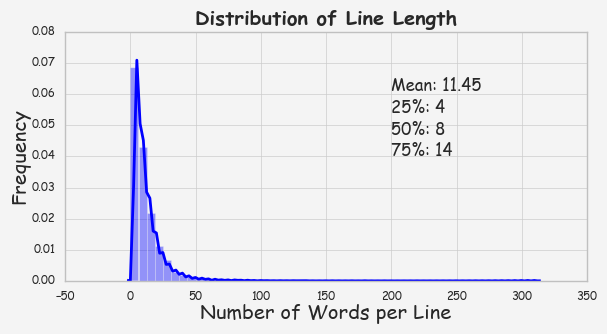

In [15]:
# plot the distribution
p = sns.distplot(lines.Word, bins = 50, color = 'blue')
p.set(xlabel = 'Number of Words per Line', ylabel = 'Frequency')
p.set_title('Distribution of Line Length', fontweight = 'bold')
p.text(200, 0.04, 'Mean: 11.45 \n25%: 4 \n50%: 8 \n75%: 14')

Over 75% of the lines are short with less than 15 words. 

In [16]:
print("Total number of words: {}".format(lines.Word.sum()))

Total number of words: 811296


### 3-2. Basic Information over Seasons

In [17]:
# group by season
byseason = lines.groupby('Season').agg({'Episode': lambda x: x.nunique(), \
                                        'Character': lambda x: x.nunique(), \
                                        'Line': 'count', 'Word': 'sum'}).reset_index()

In [18]:
byseason['Line_per_Episode'] = byseason['Line']/byseason['Episode']
byseason['Word_per_Episode'] = byseason['Word']/byseason['Episode']

In [19]:
byseason.head()

,Season,Word,Character,Line,Episode,Line_per_Episode,Word_per_Episode
0,1,40025,247,4170,13,320.769231,3078.846154
1,2,63352,442,6416,18,356.444444,3519.555556
2,3,58023,447,5798,17,341.058824,3413.117647
3,4,60250,478,5680,17,334.117647,3544.117647
4,5,48783,379,4414,14,315.285714,3484.500000


In [20]:
byseason.describe()

,Season,Word,Character,Line,Episode,Line_per_Episode,Word_per_Episode
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,9.500000,45072.000000,362.333333,3937.722222,14.277778,271.791236,3141.538844
std,5.338539,9236.274873,69.473651,1147.732435,2.108960,44.566578,253.328793
min,1.000000,32073.000000,238.000000,2305.000000,10.000000,221.500000,2710.357143
25%,5.250000,39953.000000,330.000000,3269.500000,14.000000,236.910714,2984.535714
50%,9.500000,42142.500000,372.500000,3502.000000,14.000000,252.028571,3070.565934
75%,13.750000,48750.000000,399.250000,4369.500000,14.750000,311.920168,3370.688235
max,18.000000,63352.000000,478.000000,6416.000000,18.000000,356.444444,3544.117647


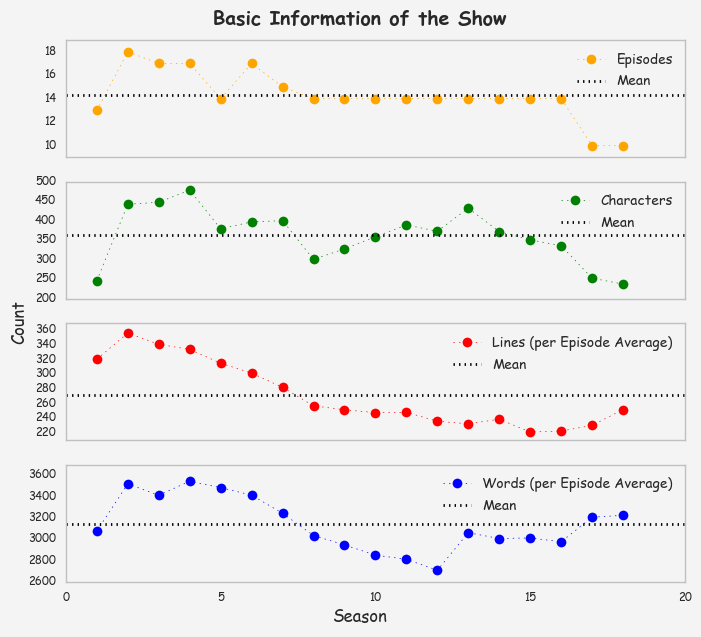

In [21]:
fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, sharey=False, figsize=(7, 6))

ax[0].plot(byseason.Season, byseason.Episode, marker = 'o', color = 'orange', linestyle=':', \
           linewidth = 0.5, label = 'Episodes')
ax[0].axhline(y=byseason.Episode.mean(), c="black",linewidth=2, linestyle=':', label = 'Mean')
ax[0].set_xlim([0, 20])
ax[0].set_ylim([9, 19])
ax[0].grid(False)
ax[0].legend()

ax[1].plot(byseason.Season, byseason.Character, marker = 'o', color = 'green', linestyle=':', \
        linewidth = 0.5, label = 'Characters')
ax[1].axhline(y=byseason.Character.mean(), c="black",linewidth=2, linestyle=':', label = 'Mean')
ax[1].set_xlim([0, 20])
ax[1].grid(False)
ax[1].legend()

ax[2].plot(byseason.Season, byseason.Line_per_Episode, marker = 'o', color = 'r', linestyle=':', \
        linewidth = 0.5, label = 'Lines (per Episode Average)')
ax[2].axhline(y=byseason.Line_per_Episode.mean(), c="black",linewidth=2, linestyle=':', label = 'Mean')
ax[2].set_xlim([0, 20])
ax[2].set_ylim([210, 370])
ax[2].grid(False)
ax[2].legend()

ax[3].plot(byseason.Season, byseason.Word_per_Episode, marker = 'o', color = 'b', linestyle=':', \
       linewidth = 0.5, label = 'Words (per Episode Average)')
ax[3].axhline(y=byseason.Word_per_Episode.mean(), c='black', linewidth=2, linestyle=':', label='Mean')
ax[3].set_xlim([0, 20])
ax[3].set_ylim([2600, 3700])
ax[3].grid(False)
ax[3].legend()
           
fig.text(0.5, 0, 'Season', ha='center')
fig.text(0, 0.5, 'Count', va='center', rotation='vertical')
fig.suptitle('Basic Information of the Show', fontsize = 14, y = 1.02)
fig.tight_layout()

In [22]:
print("Total episodes in the 18 seasons: {}".format(byseason.Episode.sum()))

Total episodes in the 18 seasons: 257


### 3-3. Characters Who Appreared in All the Seasons

In [23]:
# recuring characters
seasons = lines.Season.unique()
characters = lines.Character.unique()
print("Total number of unique characters: {}".format(len(characters)))
for season in seasons:
    character = lines[lines['Season'] == season].Character.unique()
    characters = [item for item in characters if item in character]

Total number of unique characters: 3949


In [24]:
print("Number of characters who appear in all 18 seasons: {}".format(len(characters)))
print(characters)

Number of characters who appear in all 18 seasons: 16
['Stan', 'Kyle', 'Cartman', 'Gerald', 'Mr. Mackey', 'Randy', 'Kenny', 'Clyde', 'Woman', 'Sheila', 'Man', 'Announcer', 'Sharon', 'Wendy', 'Principal Victoria', 'Liane']


### 3-4. Characters Who Spoke Most

In [25]:
# group by character
bycharacter = lines.groupby('Character').agg({'Line': 'count', 'Word': 'sum'}).reset_index()
bycharacter = bycharacter.sort_values(['Line', 'Word'], ascending = False)
bycharacter.head(10)

,Character,Line,Word
621,Cartman,9774,129680
3384,Stan,7680,68901
1832,Kyle,7099,63642
567,Butters,2602,29322
2942,Randy,2467,31087
2314,Mr. Garrison,1002,15038
681,Chef,917,11082
1785,Kenny,881,4159
3228,Sharon,862,8600
2341,Mr. Mackey,633,10680


Some of the top characters actually did not appear in all the seasons, such as Butters (who entered the show in Season 2) and Mr. Garrison.

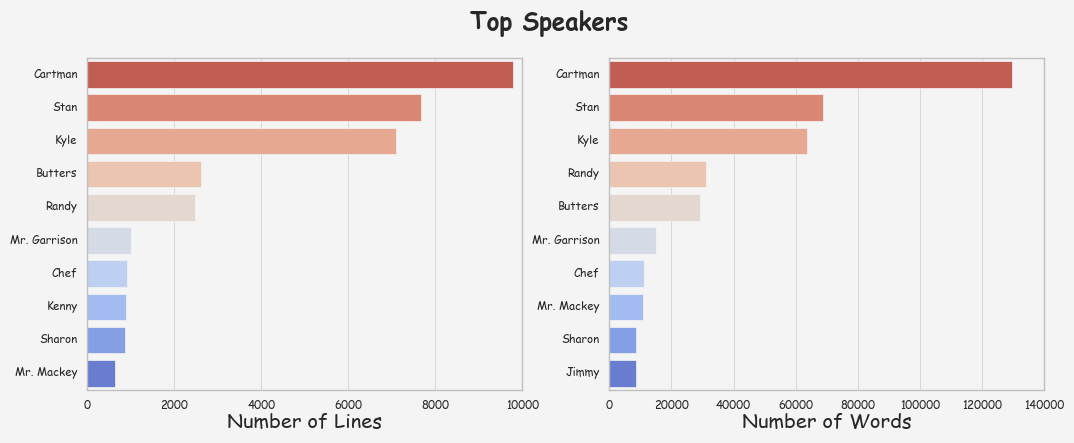

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11, 4))
sns.barplot(x = 'Line', y='Character', data=bycharacter.head(10), palette = 'coolwarm_r', ax=ax[0])
ax[0].set(xlabel='Number of Lines', ylabel='')

sns.barplot(x = 'Word', y='Character', data=bycharacter.sort_values(['Word', 'Line'], ascending = False).head(10), \
            palette = 'coolwarm_r', ax=ax[1])
ax[1].set(xlabel='Number of Words', ylabel='')

fig.suptitle('Top Speakers', y=1.02)

In [27]:
# add new variable 'Length': average length of the lines
bycharacter['Length'] = bycharacter['Word']/bycharacter['Line']
bycharacter.head(10)

,Character,Line,Word,Length
621,Cartman,9774,129680,13.267853
3384,Stan,7680,68901,8.971484
1832,Kyle,7099,63642,8.964925
567,Butters,2602,29322,11.269024
2942,Randy,2467,31087,12.601135
2314,Mr. Garrison,1002,15038,15.007984
681,Chef,917,11082,12.085060
1785,Kenny,881,4159,4.720772
3228,Sharon,862,8600,9.976798
2341,Mr. Mackey,633,10680,16.872038


In [28]:
# statistics
bycharacter.describe()

,Line,Word,Length
count,3949.000000,3949.000000,3949.000000
mean,17.948595,205.443403,10.864565
std,238.722578,2688.393553,11.164474
min,1.000000,1.000000,1.000000
25%,1.000000,6.000000,4.166667
50%,2.000000,21.000000,8.391304
75%,6.000000,72.000000,13.658537
max,9774.000000,129680.000000,163.000000


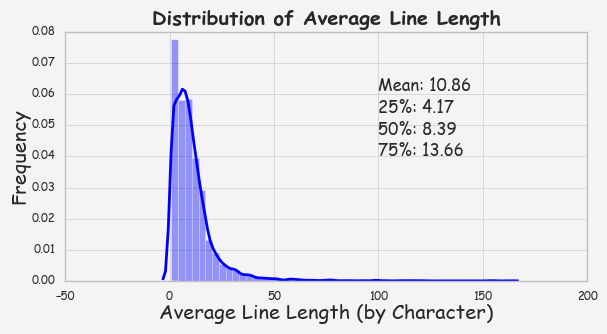

In [29]:
# distribution of average line length by character
p = sns.distplot(bycharacter.Length, bins = 50, color = 'blue')
p.set(xlabel = 'Average Line Length (by Character)', ylabel = 'Frequency')
p.set_title('Distribution of Average Line Length', fontweight = 'bold')
p.text(100, 0.04, 'Mean: 10.86 \n25%: 4.17 \n50%: 8.39 \n75%: 13.66')

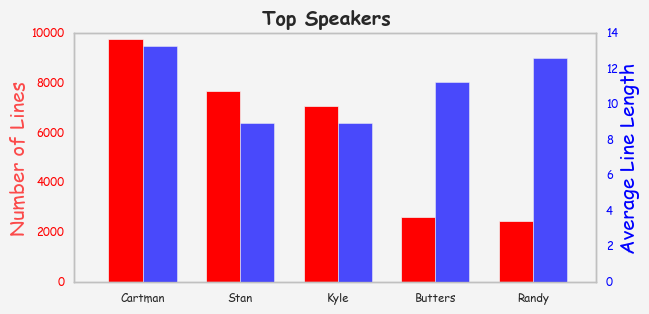

In [30]:
# plot the number of lines and the average line length for the top 5 speakers
N = 5
ind = np.arange(N) 
width = 0.35

fig, ax1 = plt.subplots()
ax1.bar(ind, bycharacter.Line[:5], width, color='r')
ax1.grid(False)
ax1.set_ylabel('Number of Lines', color='r', alpha = 0.7)
ax1.tick_params('y', colors='r')

ax2 = ax1.twinx()
ax2.bar(ind + width, bycharacter.Length[:5], width, color='b', alpha = 0.7)
ax2.grid(False)
ax2.set_ylabel('Average Line Length', color='b')
ax2.tick_params('y', colors='b')
ax2.set_xlim([-width, N])
ax2.set_xticks(ind + width)
ax2.set_xticklabels(('Cartman', 'Stan', 'Kyle', 'Butters', 'Randy'))

fig.suptitle('Top Speakers', fontsize = 14)

- Cartman, as the No.1 speaker, spoke the most lines and his lines are relatively long sentences (average line length around the 75 pencentile)
- Butters and Randy have significantly less line shares compared with Stan and Kyle, but their lines are a little longer

### 3-5. All Lines

In [31]:
# all lines
text = ' '.join(lines.Line_nopunc)

# all words in these lines (no stopwords)
word_nostopword = [word for word in text.split() if word not in STOPWORDS]

# unique words in all lines 
print("Total number of unique words (including stopwords): {}".format(len(set(text.split()))))
print("Total number of unique words (excluding stopwords): {}".format(len(set(word_nostopword))))

Total number of unique words (including stopwords): 30347
Total number of unique words (excluding stopwords): 30168


(-0.5, 1702.5, 1574.5, -0.5)

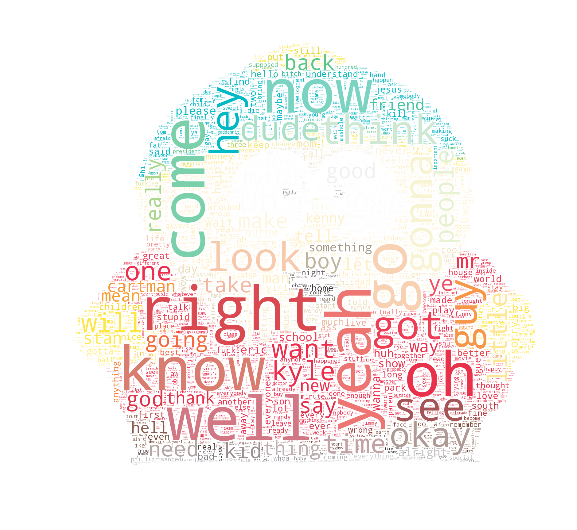

In [30]:
# wordcloud visualization
mask = imread('cartman.jpg') # mask
image_colors = ImageColorGenerator(mask) # custom color using mask image

wc = WordCloud(background_color = 'white', mask = mask, max_words = 3000, \
               stopwords = STOPWORDS, color_func = image_colors, scale = 1.0, random_state= 12)
wc.generate(text)
wc.to_file('cartman_wordcloud2.png')

plt.figure(figsize = (6, 6), facecolor = 'white')
plt.imshow(wc)
plt.axis('off')

### 3-6. Lines of top speakers

In [32]:
# top_speakers = ['Cartman', 'Stan', 'Kyle', 'Butters', 'Randy']
cartman = lines[lines['Character'] == 'Cartman']
cartman_byseason = cartman.groupby('Season').agg({'Line': 'count', 'Word': 'sum'}).reset_index()

stan = lines[lines['Character'] == 'Stan']
stan_byseason = stan.groupby('Season').agg({'Line': 'count', 'Word': 'sum'}).reset_index()

kyle = lines[lines['Character'] == 'Kyle']
kyle_byseason = kyle.groupby('Season').agg({'Line': 'count', 'Word': 'sum'}).reset_index()

butters = lines[lines['Character'] == 'Butters']
butters_byseason = butters.groupby('Season').agg({'Line': 'count', 'Word': 'sum'}).reset_index()

randy = lines[lines['Character'] == 'Randy']
randy_byseason = randy.groupby('Season').agg({'Line': 'count', 'Word': 'sum'}).reset_index()

In [33]:
# butters did not appear in season 1
butters_byseason.loc[-1] = [1, 0, 0]
butters_byseason.index = butters_byseason.index + 1  # shifting index
butters_byseason = butters_byseason.sort()  # sorting by index

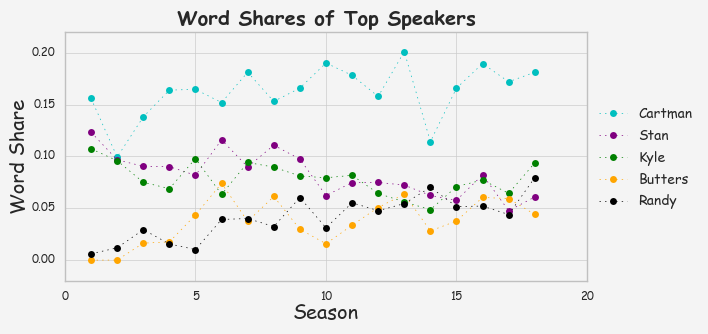

In [34]:
# plot percent of words spoken by top characters in each season
plt.plot(cartman_byseason.Season, cartman_byseason.Word/byseason.Word, marker = 'o', color = 'c', linestyle=':', \
        linewidth = 0.5, markersize = 5, label = 'Cartman')
plt.plot(stan_byseason.Season, stan_byseason.Word/byseason.Word, marker = 'o', color = 'purple', linestyle=':', \
        linewidth = 0.5, markersize = 5, label = 'Stan')
plt.plot(kyle_byseason.Season, kyle_byseason.Word/byseason.Word, marker = 'o', color = 'green', linestyle=':', \
        linewidth = 0.5, markersize = 5, label = 'Kyle')
plt.plot(butters_byseason.Season, butters_byseason.Word/byseason.Word, marker = 'o', color = 'orange', linestyle=':', \
        linewidth = 0.5, markersize = 5, label = 'Butters')
plt.plot(randy_byseason.Season, randy_byseason.Word/byseason.Word, marker = 'o', color = 'black', linestyle=':', \
        linewidth = 0.5, markersize = 5, label = 'Randy')

plt.xlim([0, 20])
plt.ylim([-0.02, 0.22])
plt.xlabel('Season')
plt.ylabel('Word Share')
plt.title('Word Shares of Top Speakers', fontweight = 'bold')
plt.legend(bbox_to_anchor=(1, 0.75), loc='upper left', ncol=1)

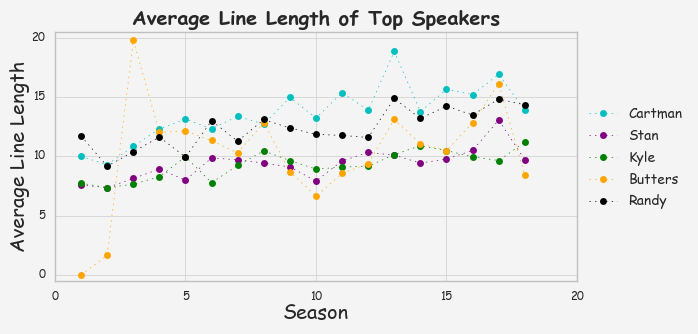

In [35]:
# plot line length of top characters in each season
plt.plot(cartman_byseason.Season, cartman_byseason.Word/cartman_byseason.Line, marker = 'o', color = 'c', linestyle=':', \
        linewidth = 0.5, markersize = 5, label = 'Cartman')
plt.plot(stan_byseason.Season, stan_byseason.Word/stan_byseason.Line, marker = 'o', color = 'purple', linestyle=':', \
        linewidth = 0.5, markersize = 5, label = 'Stan')
plt.plot(kyle_byseason.Season, kyle_byseason.Word/kyle_byseason.Line, marker = 'o', color = 'green', linestyle=':', \
        linewidth = 0.5, markersize = 5, label = 'Kyle')
plt.plot(butters_byseason.Season, butters_byseason.Word/(butters_byseason.Line + 1), marker = 'o', color = 'orange', linestyle=':', \
        linewidth = 0.5, markersize = 5, label = 'Butters')
plt.plot(randy_byseason.Season, randy_byseason.Word/randy_byseason.Line, marker = 'o', color = 'black', linestyle=':', \
        linewidth = 0.5, markersize = 5, label = 'Randy')

plt.xlim([0, 20])
plt.ylim([-0.5, 20.5])
plt.xlabel('Season')
plt.ylabel('Average Line Length')
plt.title('Average Line Length of Top Speakers', fontweight = 'bold')
plt.legend(bbox_to_anchor=(1, 0.75), loc='upper left', ncol=1)

Cartman remained to be No. 1 speaker throughout the seasons. Stan and Kyle started off similarly like Cartman but decreases later. Butters and Randy did not speak much in the first 4 seasons but they rise to be top speakers and have similar word shares as Stan and Kyle.

In [36]:
# What did butters say in season 2?
butters[butters['Season'] == 2]['Line']

35651         Me, too!
35964    Pass this up.
Name: Line, dtype: object

In [37]:
# Butters' first line in season 3
df = butters[(butters['Season'] == 3) & (butters['Episode'] == 8)]
df['Line'][40973]

"Hey, Stan. Why I-I-I sure am glad you're here, 'cause then we'll have even more fun than we, why, than we was havin' before. Why, we wuh, we were havin' an awfully good time before you showed up, too, however."

In [38]:
# who else are top speakers when the show started (season 1)?
bycharacter_s1 = lines[lines['Season'] == 1].groupby('Character').agg({'Line': 'count', 'Word': 'sum'}).reset_index()
bycharacter_s1 = bycharacter_s1.sort_values(['Line', 'Word'], ascending = False)
bycharacter_s1.head()

,Character,Line,Word
209,Stan,651,4934
33,Cartman,624,6238
111,Kyle,555,4296
35,Chef,251,3057
142,Mr. Garrison,212,2898


### 3-7. Words by Characters

#### Word frequency

In [39]:
# combine lines by character
character_lines = lines.groupby('Character')['Line_nopunc'].apply(list).reset_index()
character_lines['Line_nopunc'] = character_lines['Line_nopunc'].apply(lambda x: ' '.join(x))

In [40]:
# put lines together into a text file for each top speaker
cartman_text = ''.join(character_lines[character_lines['Character'] == 'Cartman']['Line_nopunc'])
stan_text = ''.join(character_lines[character_lines['Character'] == 'Stan']['Line_nopunc'])
kyle_text = ''.join(character_lines[character_lines['Character'] == 'Kyle']['Line_nopunc'])
butters_text = ''.join(character_lines[character_lines['Character'] == 'Butters']['Line_nopunc'])
randy_text = ''.join(character_lines[character_lines['Character'] == 'Randy']['Line_nopunc'])

In [41]:
from collections import Counter

# mostly spoken words for the top speakers (exclude stopwords)
# cartman 
cartman_word = [w for w in cartman_text.split()]
cartman_nostopword = [w for w in cartman_word if w not in list(STOPWORDS)]
cartman_mostfreq = Counter(cartman_nostopword).most_common(20)
cartman_df = pd.DataFrame(cartman_mostfreq, columns = ['Word', 'Count'])

# stan
stan_word = [w for w in stan_text.split()]
stan_nostopword = [w for w in stan_word if w not in list(STOPWORDS)]
stan_mostfreq = Counter(stan_nostopword).most_common(20)
stan_df = pd.DataFrame(stan_mostfreq, columns = ['Word', 'Count'])

# kyle
kyle_word = [w for w in kyle_text.split()]
kyle_nostopword = [w for w in kyle_word if w not in list(STOPWORDS)]
kyle_mostfreq = Counter(kyle_nostopword).most_common(20)
kyle_df = pd.DataFrame(kyle_mostfreq, columns = ['Word', 'Count'])

# butters
butters_word = [w for w in butters_text.split()]
butters_nostopword = [w for w in butters_word if w not in list(STOPWORDS)]
butters_mostfreq = Counter(butters_nostopword).most_common(20)
butters_df = pd.DataFrame(butters_mostfreq, columns = ['Word', 'Count'])

# randy
randy_word = [w for w in randy_text.split()]
randy_nostopword = [w for w in randy_word if w not in list(STOPWORDS)]
randy_mostfreq = Counter(randy_nostopword).most_common(20)
randy_df = pd.DataFrame(randy_mostfreq, columns = ['Word', 'Count'])

(0.0, 1.0, 0.0, 1.0)

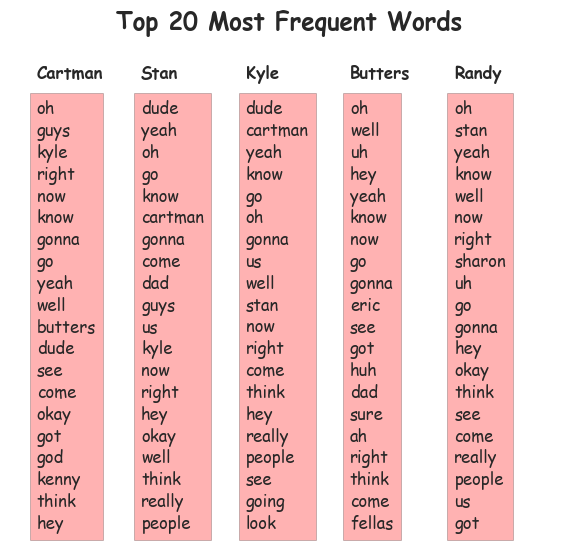

In [42]:
fig = plt.figure(figsize=(6, 5.7), facecolor = 'white')
ax = fig.add_subplot(111)

ax.text(0.0, 0, '\n'.join(cartman_df.Word), bbox={'facecolor': 'red', 'edgecolor': 'black', 'alpha': 0.3, 'pad':5})
ax.text(0.0, 0.95, 'Cartman', fontweight='bold')
ax.text(0.2, 0, '\n'.join(stan_df.Word), bbox={'facecolor': 'red', 'edgecolor': 'black', 'alpha': 0.3, 'pad':5})
ax.text(0.2, 0.95, 'Stan', fontweight='bold')
ax.text(0.4, 0, '\n'.join(kyle_df.Word), bbox={'facecolor': 'red', 'edgecolor': 'black', 'alpha': 0.3, 'pad':5})
ax.text(0.4, 0.95, 'Kyle', fontweight='bold')
ax.text(0.6, 0, '\n'.join(butters_df.Word), bbox={'facecolor': 'red', 'edgecolor': 'black', 'alpha': 0.3, 'pad':5})
ax.text(0.6, 0.95, 'Butters', fontweight='bold')
ax.text(0.8, 0, '\n'.join(randy_df.Word), bbox={'facecolor': 'red', 'edgecolor': 'black', 'alpha': 0.3, 'pad':5})
ax.text(0.8, 0.95, 'Randy', fontweight='bold')

fig.suptitle('Top 20 Most Frequent Words', fontweight='bold')
plt.axis('off')

#### TF IDF

In [43]:
def top_tfidf_feats(row, features, top_n=20):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(vec, features, row_id, top_n=20):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(vec[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec_1g = TfidfVectorizer(ngram_range=(1, 1), stop_words=STOPWORDS)
vec_2g = TfidfVectorizer(ngram_range=(2, 3), stop_words=STOPWORDS)

doc = character_lines.Line_nopunc

vec_1g.fit(doc)
features_1g = vec_1g.get_feature_names()
vec1 = vec_1g.transform([' '.join(cartman_nostopword)] + [' '.join(stan_nostopword)] + \
                        [' '.join(kyle_nostopword)] + [' '.join(butters_nostopword)] + \
                        [' '.join(randy_nostopword)])

vec_2g.fit(doc)
features_2g = vec_2g.get_feature_names()
vec2 = vec_2g.transform([' '.join(cartman_nostopword)] + [' '.join(stan_nostopword)] + \
                        [' '.join(kyle_nostopword)] + [' '.join(butters_nostopword)] + \
                        [' '.join(randy_nostopword)])

In [45]:
# find out words with the highest tfidf
cartman_top1g = top_feats_in_doc(vec1, features_1g, row_id=0, top_n=20)
stan_top1g = top_feats_in_doc(vec1, features_1g, row_id=1, top_n=20)
kyle_top1g = top_feats_in_doc(vec1, features_1g, row_id=2, top_n=20)
butters_top1g = top_feats_in_doc(vec1, features_1g, row_id=3, top_n=20)
randy_top1g = top_feats_in_doc(vec1, features_1g, row_id=4, top_n=20)

cartman_top2g = top_feats_in_doc(vec2, features_2g, row_id=0, top_n=20)
stan_top2g = top_feats_in_doc(vec2, features_2g, row_id=1, top_n=20)
kyle_top2g = top_feats_in_doc(vec2, features_2g, row_id=2, top_n=20)
butters_top2g = top_feats_in_doc(vec2, features_2g, row_id=3, top_n=20)
randy_top2g = top_feats_in_doc(vec2, features_2g, row_id=4, top_n=20)

(0.0, 1.0, 0.0, 1.0)

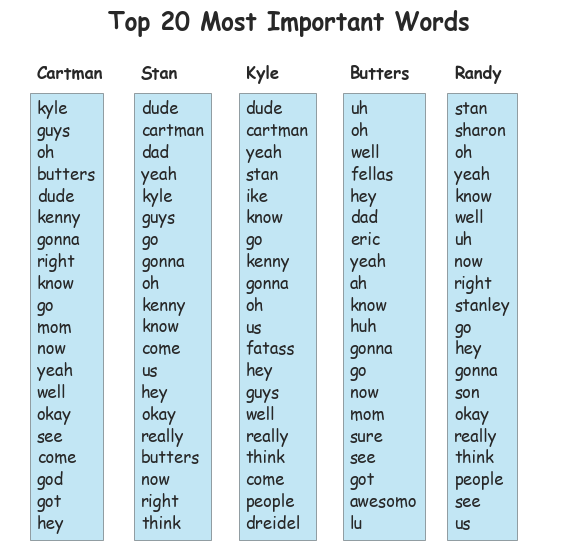

In [46]:
fig = plt.figure(figsize=(6, 5.7), facecolor = 'white')
ax = fig.add_subplot(111)

ax.text(0.0, 0, '\n'.join(cartman_top1g.feature), bbox={'facecolor': 'skyblue', 'edgecolor': 'black', 'alpha': 0.5, 'pad':5})
ax.text(0.0, 0.95, 'Cartman', fontweight='bold')
ax.text(0.2, 0, '\n'.join(stan_top1g.feature), bbox={'facecolor': 'skyblue', 'edgecolor': 'black', 'alpha': 0.5, 'pad':5})
ax.text(0.2, 0.95, 'Stan', fontweight='bold')
ax.text(0.4, 0, '\n'.join(kyle_top1g.feature), bbox={'facecolor': 'skyblue', 'edgecolor': 'black', 'alpha': 0.5, 'pad':5})
ax.text(0.4, 0.95, 'Kyle', fontweight='bold')
ax.text(0.6, 0, '\n'.join(butters_top1g.feature), bbox={'facecolor': 'skyblue', 'edgecolor': 'black', 'alpha': 0.5, 'pad':5})
ax.text(0.6, 0.95, 'Butters', fontweight='bold')
ax.text(0.8, 0, '\n'.join(randy_top1g.feature), bbox={'facecolor': 'skyblue', 'edgecolor': 'black', 'alpha': 0.5, 'pad':5})
ax.text(0.8, 0.95, 'Randy', fontweight='bold')

fig.suptitle('Top 20 Most Important Words', fontweight='bold')
plt.axis('off')

(0.0, 1.0, 0.0, 1.0)

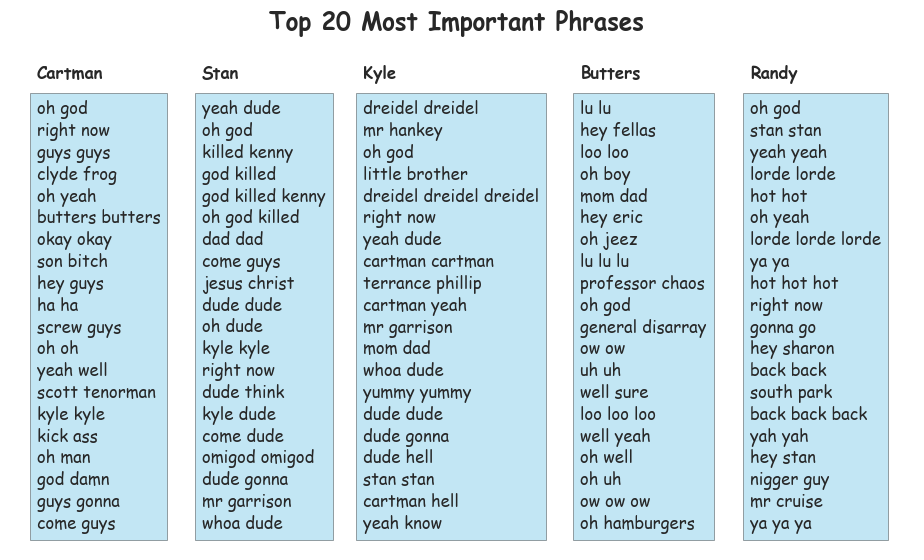

In [47]:
fig = plt.figure(figsize=(10, 5.7), facecolor = 'white')
ax = fig.add_subplot(111)

ax.text(0.0, 0, '\n'.join(cartman_top2g.feature), bbox={'facecolor': 'skyblue', 'edgecolor': 'black', 'alpha': 0.5, 'pad':5})
ax.text(0.0, 0.95, 'Cartman', fontweight='bold')
ax.text(0.19, 0, '\n'.join(stan_top2g.feature), bbox={'facecolor': 'skyblue', 'edgecolor': 'black', 'alpha': 0.5, 'pad':5})
ax.text(0.19, 0.95, 'Stan', fontweight='bold')
ax.text(0.375, 0, '\n'.join(kyle_top2g.feature), bbox={'facecolor': 'skyblue', 'edgecolor': 'black', 'alpha': 0.5, 'pad':5})
ax.text(0.375, 0.95, 'Kyle', fontweight='bold')
ax.text(0.625, 0, '\n'.join(butters_top2g.feature), bbox={'facecolor': 'skyblue', 'edgecolor': 'black', 'alpha': 0.5, 'pad':5})
ax.text(0.625, 0.95, 'Butters', fontweight='bold')
ax.text(0.82, 0, '\n'.join(randy_top2g.feature), bbox={'facecolor': 'skyblue', 'edgecolor': 'black', 'alpha': 0.5, 'pad':5})
ax.text(0.82, 0.95, 'Randy', fontweight='bold')

fig.suptitle('Top 20 Most Important Phrases', fontweight='bold')
plt.axis('off')

In [48]:
# find some special bigrams (they are more likely to form bigram than as individual words) 
from sklearn.feature_extraction.text import CountVectorizer

def get_count(n):
    '''return a dictionary with n-gram and their counts'''
    vect = CountVectorizer(stop_words='english', ngram_range=(n, n))
    counts = vect.fit_transform(doc)
    gram = vect.get_feature_names()
    counts_list = counts.sum(axis = 0)
    counts_list = np.asarray(counts_list).reshape(-1)
    gram_count = dict(zip(gram, counts_list))
    
    return gram_count

count_1g = get_count(1)
count_2g = get_count(2)

import operator

def find_special(count1, count2):
    '''return the top 20 special bigrams'''
    ratio = {}
    for bigram in count2:
        words = bigram.split()
        k1 = words[0]
        k2 = words[1]
        if k1 in count1 and k2 in count1:
            ratio[bigram] = float(count2[bigram])/((count1[k1] + 50)*(count1[k2] + 50)) # bayesian smoothing
    sorted_ratio = sorted(ratio.items(), key=operator.itemgetter(1), reverse=True)
    return sorted_ratio[:20]

find_special(count_1g, count_2g)

[('mel gibson', 0.0047743055555555559),
 ('casa bonita', 0.0047332185886402754),
 ('trapper keeper', 0.0046474035158617904),
 ('prime minister', 0.0045582047685834501),
 ('kathie lee', 0.0044973544973544973),
 ('global warming', 0.0044532409698169219),
 ('los angeles', 0.0043186895011169029),
 ('rabble rabble', 0.0043044077134986227),
 ('cheesy poofs', 0.0043010752688172043),
 ('barbra streisand', 0.004097818902842036),
 ('meow meow', 0.003955895968352832),
 ('founding fathers', 0.0038377192982456138),
 ('phil collins', 0.0037071362372567192),
 ('san francisco', 0.0036910457963089541),
 ('pinewood derby', 0.0035502958579881655),
 ('mintberry crunch', 0.0035035035035035035),
 ('biggie smalls', 0.003472892147404978),
 ('okama gamesphere', 0.003383084577114428),
 ('customer service', 0.0033663366336633663),
 ('christopher reeve', 0.003335804299481097)]

#### What did Kenny say

In [49]:
kenny_text = ''.join(character_lines[character_lines['Character'] == 'Kenny']['Line_nopunc'])

(-0.5, 354.5, 478.5, -0.5)

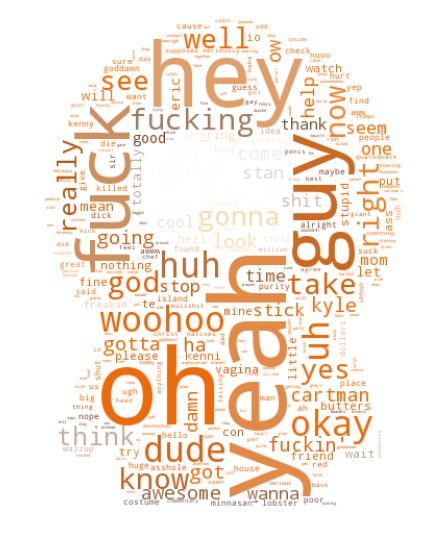

In [50]:
mask = imread('kenny.jpg') # mask
image_colors = ImageColorGenerator(mask) # custom color using mask image

wc = WordCloud(background_color = 'white', mask = mask, max_words = 3000, \
               stopwords = STOPWORDS, color_func = image_colors, scale = 1.0, random_state= 10)
wc.generate(kenny_text)
wc.to_file('kenny_wordcloud.png')

plt.figure(figsize = (6, 6), facecolor = 'white')
plt.imshow(wc)
plt.axis('off')

In [51]:
kenny_word = [w for w in kenny_text.split()]
kenny_nostopword = [w for w in kenny_word if w not in list(STOPWORDS)]

vec1_k = vec_1g.transform([' '.join(kenny_nostopword)])
vec2_k = vec_2g.transform([' '.join(kenny_nostopword)])
kenny_top1g = top_feats_in_doc(vec1_k, features_1g, row_id=0, top_n=20)
kenny_top2g = top_feats_in_doc(vec2_k, features_2g, row_id=0, top_n=20)

In [52]:
kenny_top1g

,feature,tfidf
0,yeah,0.434546
1,fuck,0.282016
2,woohoo,0.278473
3,dude,0.246265
4,guys,0.233252
5,hey,0.233143
6,oh,0.215685
7,fucking,0.162086
8,okay,0.135240
9,huh,0.125770


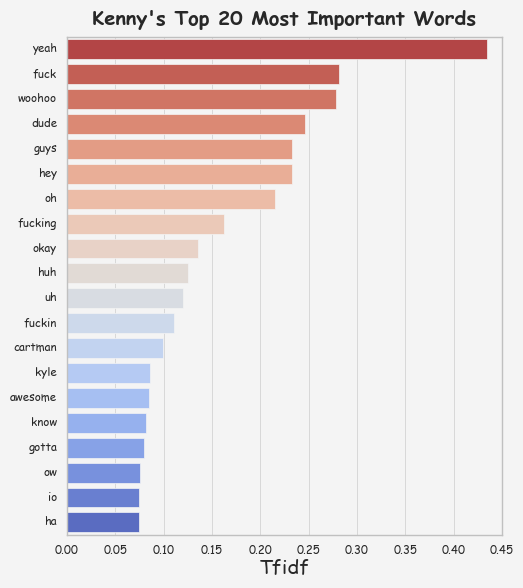

In [53]:
# plot the top 20 most important words
fig = plt.figure(figsize=(5, 6))
fig = sns.barplot(x='tfidf', y='feature', data=kenny_top1g, palette='coolwarm_r')
fig.set(xlabel='Tfidf', ylabel='')
fig.set_title("Kenny's Top 20 Most Important Words", fontweight='bold', y=1.01)

In [54]:
kenny_top2g

,feature,tfidf
0,hey guys,0.141637
1,yeah yeah,0.113497
2,uh huh,0.095976
3,dude fuck,0.085868
4,yeah totally,0.074966
5,fuck yeah,0.073601
6,woohoo yeah,0.071321
7,con te,0.069687
8,oh god,0.066066
9,purincessu kenni,0.063784
